# <center>Metody Numeryczne</center>

# Laboratorium 6: Iteracyjne równania liniowe i macierze rzadkie


**Wykonał:** Kacper Pastuła

<br>

### **Metoda zaliczenia:**

Podczas zajęć należy wykonać poniższe polecenia oraz udzielić odpowiedzi na pytania zamieszczone w treści zadań. 

Wszystkie funkcje wymagane w ramach ćwiczenia należy zaimplementować w pliku `main.py`. Poprawność ich działania należy zweryfikować za pomocą testów jednostkowych dostępnych w pliku `test_main.py`.

### **Cel zajęć:**

Celem zajęć jest zapoznanie się z numerycznymi metodami rozwiązywania układów równań liniowych w postaci macierzowej, w szczególności z wykorzystaniem rzadkich macierzy prostokątnych.


Dana jest prostokątna, [rzadka](https://en.wikipedia.org/wiki/Sparse_matrix) macierz $\mathbf{A}$ o wymiarach $m \times n$ oraz wektor kolumnowy $\mathbf{b}$ o wymiarach $m \times 1$. Należy rozwiązać układ równań postaci:
 
$$
\mathbf{Ax}=\mathbf{b}
$$
  
gdzie:
- $\mathbf{A}$ - macierz współczynników z lewej strony równania, 
- $\mathbf{x}$ - wektor kolumnowy zmiennych,
- $\mathbf{b}$ - wektor kolumnowy wyników prawej strony równania. 

Do oceny jakości rozwiązania wykorzystywać będziemy residuum (ang. *residual*):

$$
\mathbf{r}=\mathbf{b}-\mathbf{Ax}
$$


### **Uwagi wstępne:**
- Funkcje wymagające implementacji (lub zaimplementowane na poprzednich laboratoriach) oznaczone są pochyłą czcionką maszynową (np. *`my_func()`*).

- W skrypcie stosuje się następujące skróty:

    - `np` - `numpy`,
    - `sp` - `scipy`.

---

In [3]:
# !python -m pip install numpy scipy matplotlib

import main

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

---

### **Zadanie 1.**

W macierzach rzadkich większość elementów jest zerami, więc przechowywanie całych macierzy w pamięci jest nieefektywne. W celu optymalizacji macierze te zapisuje się w przeznaczonych do tego [formatach przechowywania danych](https://docs.scipy.org/doc/scipy/reference/sparse.html#usage-information), jakie udostępnia m.in. moduł [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html). W ramach laboratorium korzystać będziemy z formatu [Compressed Sparse Column (CSC)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_array.html).

1. Zapoznaj się z różnymi formatami przechowywania macierzy rzadkich w pamięci.

2. Dla $10$ równo rozmieszczonych wartości $m$ z zakresu $[100, 10000]$ wygeneruj macierze rzadkie wymiaru $m \times m$ używając [`sp.sparse.random_array()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.random_array.html) z parametrem `density=0.01` oraz parametrem `format` ustawionym tak, aby wygenerowane macierze zapisane zostały w formacie CSC.

2. Porównaj ile pamięci zajmują te same macierze zapisane w formacie `numpy.ndarray` oraz w formacie `scipy.sparse.csc_array`. W tym celu przekonwertuj kopie macierzy utworzonych w poprzednim punkcie do formatu `numpy.ndarray` używając odpowiedniej metody z modułu `scipy.sparse`. Wynik zaprezentuj na jednym wykresie typu *scatter plot*.

3. Opisz wnioski wynikające z wykresu.

> **Wskazówka:** Do obliczenia rozmiaru zmiennych skorzystaj z fragmentu kodu podanego poniżej.


In [44]:
# Fragment kodu wyznaczający ilość zużycia pamięci przez macierze (w bajtach).
size = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
macierze = []
n_memory_size = []
s_memory_size = []
for m in size:
    macierze.append(sp.sparse.random_array((m,m),format = 'csc'))
for m in macierze:
    n_memory_size.append((m.toarray()).nbytes)
    s_memory_size.append(m.data.nbytes + m.indices.nbytes + m.indptr.nbytes)


Text(0.5, 0, 'rozmiar macierzy kwadratowej')

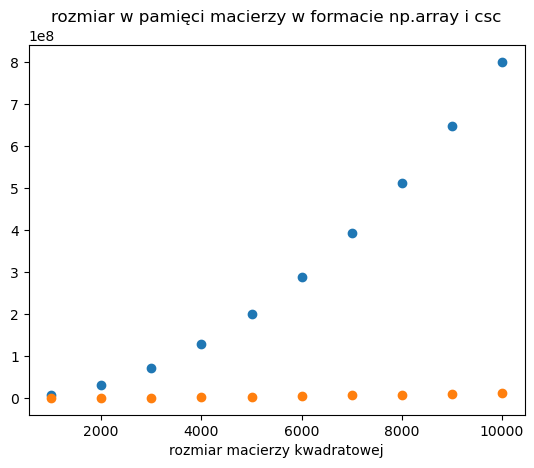

In [47]:
# ===== Twoja implementacja tutaj =====

plt.scatter(size, n_memory_size)
plt.scatter(size, s_memory_size)
plt.title('rozmiar w pamięci macierzy w formacie np.array i csc')
plt.xlabel('rozmiar macierzy kwadratowej')


---

### **Zadanie 2.**

Korzystając z wiedzy zdobytej podczas realizacji **Zadania 1.** wykonaj polecenia.

1. Wygeneruj macierze rzadkie $\mathbf{A}$ i $\mathbf{B}$ o wymiarach $1000 \times 1000$. Zapisz je w formatach `scipy.sparse.csc_array` oraz `numpy.ndarray`.

2. Porównaj czas potrzebny na wykonanie mnożenia macierzowego $\mathbf{AB}$ dla macierzy zapisanych w formacie `numpy.ndarray` oraz `scipy.sparse.csc_array`.

3. Opisz z czego wynika różnica.

In [56]:
# ===== Twoja implementacja tutaj =====
m = 1000
A_csc = sp.sparse.random_array((m,m), format = 'csc')
B_csc = sp.sparse.random_array((m,m), format = 'csc')
A_nparray = A_csc.toarray()
B_nparray = B_csc.toarray()
timing_A = %timeit -r 5 -n 10 -o A_nparray@B_nparray
timing_B = %timeit -r 5 -n 10 -o A_csc@B_csc
print("czas potrzebny aby wymnożyć macierze w formacie nparray: {}ms".format(timing_A.average * 1000))
print("czas potrzebny aby wymnożyć macierze w formacie csc: {}ms".format(timing_B.average * 1000))

11.5 ms ± 236 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)
738 μs ± 9.19 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)
czas potrzebny aby wymnożyć macierze w formacie nparray: 11.487021999200806ms
czas potrzebny aby wymnożyć macierze w formacie csc: 0.7378760003484786ms


---

### **Zadanie 3.**

Aby metody iteracyjne znalazły rozwiązanie układu równań $\mathbf{Ax}=\mathbf{b}$ należy zadbać o to aby macierz $\mathbf{A}$ była [diagonalnie zdominowana](https://en.wikipedia.org/wiki/Diagonally_dominant_matrix). Przekształcenie dowolnej macierzy do tej postaci jest skomplikowanym zagadnieniem, które nie będzie poruszane w ramach tego laboratorium. Na potrzeby zadania należy jedynie sprawdzić czy używana macierz posiada tę własność.

**Punkt 1.**

Zaimplementuj funkcję *`is_diagonally_dominant()`* sprawdzającą czy macierz jest diagonalnie zdominowana.

> **Wskazówka:** W implementacji nie należy używać pętli *for*, ponieważ biblioteka NumPy zawiera funkcje, które znacznie wydajniej iterują po elementach tablic typu `numpy.ndarray`. Lepiej skorzystać z funkcji [`np.sum()`](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) oraz [`np.diagonal()`](https://numpy.org/doc/stable/reference/generated/numpy.diagonal.html).

<br>

**Punkt 2.**

Poniżej znajduje się zaimplementowana funkcja `generate_matrix()`. Przy jej pomocy wygeneruj macierz $\mathbf{A}$ o wymiarach $1000 \times 1000$. Następnie zweryfikuj czy wygenerowana macierz jest diagonalnie zdominowana. Wygeneruj również wektor wartości losowych $\mathbf{b}$ o długości $1000$.

<br>

**Punkt 3.**

Istnieje wiele metod iteracyjnego rozwiązywania równań, natomiast nie różnią się one znacząco od siebie w kwestii wywołania metody, dlatego w dalszej części zadania należy wybrać jedną z metod: [GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html) lub [Conjugate Gradient](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html) i dla niej przeprowadzić dalszą analizę. 

1. Korzystając z funkcji *`residual_norm()`*, oraz macierzy zdefiniowanych w **Punkcie 2.**, zbadaj wpływ argumentów `rtol` i `maxiter` na działanie wybranej metody. Sporządź wykresy przedstawiające wartość normy residuum w zależności od zmiany podanych parametrów.

2. Opisz zaobserwowane zależności.

>**Wskazówka:** Metoda *Conjugate Gradient* wymaga aby macierz była dodatnio określona. Można to zapewnić poprzez podanie argumentu `is_symmetric=True` do funkcji `generate_matrix()`.


In [5]:
# Implementacja funkcji generate_matrix().

from scipy.sparse import diags_array, csc_array


def generate_matrix(m: int = 1000, is_symmetric: bool = False) -> csc_array:
    """Funkcja generująca rzadką, diagonalnie zdominowaną macierz rozmiaru m x m.

    Parameters:
        m (int): Wymiar macierzy.
        is_symmetric (bool): Czy macierz ma być symetryczna.

    Returns:
        (scipy.sparse.csc_array): Macierz rzadka, diagonalnie zdominowana (m,m).

    Raises:
        TypeError: Jeśli 'm' nie jest liczbą całkowitą lub 'is_symmetric' nie 
            jest wartością logiczną.
        ValueError: Jeśli 'm' jest mniejsze niż 5.
    """
    if not isinstance(m, int):
        raise TypeError(
            f"Argument 'm' musi być liczbą całkowitą, otrzymano: {type(m).__name__}."
        )
    if not isinstance(is_symmetric, bool):
        raise TypeError(
            f"Argument 'is_symmetric' musi być wartością logiczną, otrzymano: {type(is_symmetric).__name__}."
        )
    if m < 5:
        raise ValueError("Argument 'm' musi być większy lub równy 5.")

    if is_symmetric:
        num_upper_diags = np.random.randint(2, m // 2)
        diagonal_values = np.random.rand(num_upper_diags)
        matrix = diags_array(
            diagonal_values, offsets=np.arange(1, num_upper_diags + 1), shape=(m, m)
        )
        matrix = matrix + matrix.T
    else:
        num_upper_diags = np.random.randint(2, m // 2)
        num_lower_diags = np.random.randint(2, m // 2)
        diagonal_values = np.random.rand(num_upper_diags + num_lower_diags)
        matrix = diags_array(
            diagonal_values,
            offsets=np.arange(-num_lower_diags, num_upper_diags),
            shape=(m, m),
        )

    row_sums = np.asarray(matrix.sum(axis=1)).flatten()
    diagonal_vals = row_sums - np.abs(matrix.diagonal()) + np.random.rand(m)
    matrix.setdiag(diagonal_vals)

    return matrix.tocsc()

In [62]:
# ===== Twoja implementacja tutaj =====
A = [[1, 2, 3],[4, 5, 6],[7, 8, 9]]
print(np.sum(A,1))
print(np.diagonal(A))

[ 6 15 24]
[1 5 9]


---

**Materiały uzupełniające:**
- [Scipy Lecture Notes](http://www.scipy-lectures.org/index.html)
- [NumPy for Matlab users](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html#numpy-for-matlab-users)
- [Python Tutorial - W3Schools](https://www.w3schools.com/python/default.asp)
- [NumPy](https://www.numpy.org)
- [Matplotlib](https://matplotlib.org/)
- [Anaconda](https://www.anaconda.com/)
- [Learn Python for Data Science](https://www.datacamp.com/learn-python-with-anaconda?utm_source=Anaconda_download&utm_campaign=datacamp_training&utm_medium=banner)
- [Learn Python](https://www.learnpython.org/)
- [Wujek Google](https://google.pl) i [Ciocia Wikipedia](https://pl.wikipedia.org/wiki/Wikipedia:Strona_g%C5%82%C3%B3wna)